In [2]:
%env CUDA_VISIBLE_DEVICES=4
from util import *
from problems import *
from catformer import CatFormer
import optax
from plots import *

env: CUDA_VISIBLE_DEVICES=4


/data/eshaan/anaconda3/envs/jax/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/data/eshaan/anaconda3/envs/jax/lib/python3.8/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


0 []
1 []
2 [0, 1]
3 [1, 2]
4 [1, 3]
5 [2, 4]
6 [2, 5]
7 [3, 6]
8 [3, 7]
9 [4, 8]
10 [4, 9]
11 [5, 10]
12 [5, 11]
13 [6, 12]
14 [6, 13]
15 [7, 14]
16 [7, 15]
17 [8, 16]
18 [8, 17]
19 [9, 18]
20 [9, 19]
21 [10, 20]
22 [10, 21]
23 [11, 22]
24 [11, 23]
25 [12, 24]
26 [12, 25]
27 [13, 26]
28 [13, 27]
29 [14, 28]
30 [14, 29]
31 [15, 30]
32 [15, 31]


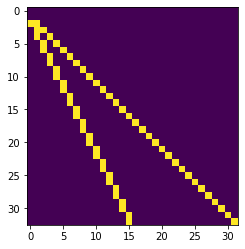

In [3]:
rng = RNG(0)
vocab_size = 5
seq_len = 32
alpha = 0.1
init_model = CatFormer(
    seq_len=seq_len,
    vocab_size=vocab_size,
    heads=[2, 1],
)

# dag = []
# for i in range(seq_len + 1):
#     if i < 2:
#         dag.append([])
#     else:
#         dag.append(np.sort(np.random.choice(i, (2,), replace=False)))

dag = [[], []] + [[(i - 1) // 2, i - 1] for i in range(2, seq_len + 1)]

problem = InContextDAG(
    vocab_size=vocab_size,
    dag=dag,
    alpha=alpha,
)
dag = problem.dag


@jit
def criterion(f, y):
    _criterion = lambda f, y: -jnp.log(f) @ y
    for _ in range(y.ndim - 1):
        _criterion = vmap(_criterion)
    return _criterion(f, y).mean()


@jit
def loss_fn(model, batch):
    x, y = batch
    return criterion(model(x), y)


A = jnp.zeros((seq_len + 1, seq_len), dtype=int)
for i in range(seq_len + 1):
    A = A.at[i, dag[i]].set(1)
plt.imshow(A)

In [4]:
print("Computing Bayes")
testx, testy = vmap(problem.sample)(rng.next(2**16))
logits = vmap(problem.bayes)(testx)
bayes = criterion(logits, testy)

one_nn = dag[:2] + [[x[1]] for x in dag[2:]]
one_nn = InContextDAG(
    vocab_size=vocab_size,
    dag=one_nn,
    alpha=alpha,
)
logits = vmap(one_nn.bayes)(testx)
one_nn = criterion(logits, testy)

print("Training")
lr = 1e-2
wd = 1e-4
steps = 2**16
save_every = steps // 128
batch_size = 2**10
max_size = 2**15
epoch_len = max_size // batch_size
sample_fn = jit(lambda k: vmap(problem.sample)(jr.split(k, epoch_len * batch_size)))


def batch_iterator(key):
    while True:
        key, subkey = jr.split(key)
        batches = sample_fn(subkey)
        for i in range(epoch_len):
            yield tree_map(lambda x: x[batch_size * i : batch_size * (i + 1)], batches)


schedule = optax.cosine_decay_schedule(lr, steps)
# opt = optax.chain(optax.add_decayed_weights(wd), optax.sgd(schedule))
opt = optax.adamw(schedule, weight_decay=wd)


@jit
def step_fn(model, batch, opt_state):
    g = jax.grad(loss_fn)(model, batch)
    updates, opt_state = opt.update(g, opt_state, model)
    model = optax.apply_updates(model, updates)
    return model, opt_state


iterator = batch_iterator(rng.next())
model = init_model
for i in range(len(model.A)):
    model.A[i] = 1e-4 * rng.normal(model.A[i].shape)

opt_state = opt.init(model)
losses = []
for i in trange(steps):
    if i % save_every == 0:
        losses.append([i, loss_fn(model, (testx, testy))])
    model, opt_state = step_fn(model, next(iterator), opt_state)
ts, losses = tree_stack(losses)

Computing Bayes
0 []
1 []
2 [Array(1, dtype=int32)]
3 [Array(2, dtype=int32)]
4 [Array(3, dtype=int32)]
5 [Array(4, dtype=int32)]
6 [Array(5, dtype=int32)]
7 [Array(6, dtype=int32)]
8 [Array(7, dtype=int32)]
9 [Array(8, dtype=int32)]
10 [Array(9, dtype=int32)]
11 [Array(10, dtype=int32)]
12 [Array(11, dtype=int32)]
13 [Array(12, dtype=int32)]
14 [Array(13, dtype=int32)]
15 [Array(14, dtype=int32)]
16 [Array(15, dtype=int32)]
17 [Array(16, dtype=int32)]
18 [Array(17, dtype=int32)]
19 [Array(18, dtype=int32)]
20 [Array(19, dtype=int32)]
21 [Array(20, dtype=int32)]
22 [Array(21, dtype=int32)]
23 [Array(22, dtype=int32)]
24 [Array(23, dtype=int32)]
25 [Array(24, dtype=int32)]
26 [Array(25, dtype=int32)]
27 [Array(26, dtype=int32)]
28 [Array(27, dtype=int32)]
29 [Array(28, dtype=int32)]
30 [Array(29, dtype=int32)]
31 [Array(30, dtype=int32)]
32 [Array(31, dtype=int32)]
Training


  0%|          | 0/65536 [00:00<?, ?it/s]

Text(0.5, 0.98, 'seq len=32')

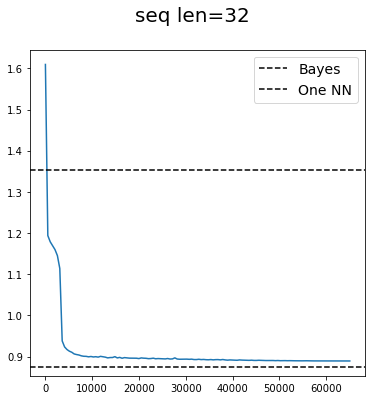

In [5]:
fig = plt.figure(figsize=(6, 6))
plt.plot(ts, losses)
plt.axhline(bayes, c="k", ls="--", label="Bayes")
plt.axhline(one_nn, c="k", ls="--", label="One NN")
plt.legend(fontsize=14)
fig.suptitle(f"seq len={seq_len}", fontsize=20)

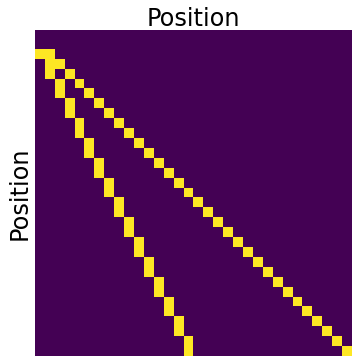

In [7]:
from plots import *
from pathlib import Path

savedir = Path(f"figs")
fig = plot_A(A)
plt.savefig(
    savedir / "A.png",
    bbox_inches="tight",
    dpi=200,
)

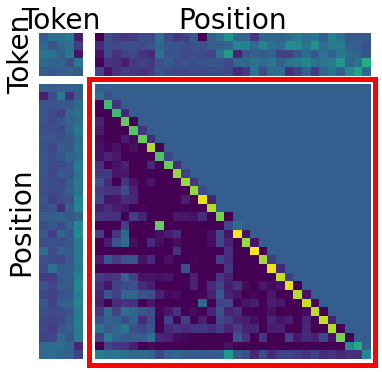

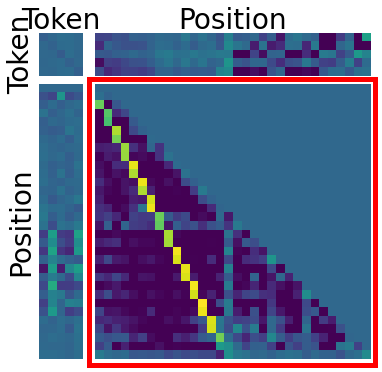

In [8]:
for i in range(2):
    fig = plot_A1(
        model.A[0][i],
        vocab_size,
        seq_len,
        15,
        100,
        fontsize=28,
        patch=True,
    )
    plt.savefig(
        savedir / f"A1_{i}.png",
        bbox_inches="tight",
        dpi=200,
    )

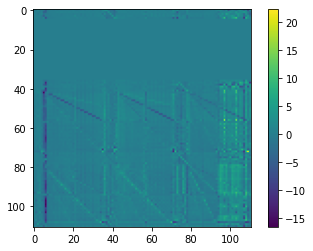

In [9]:
plt.imshow(model.A[1][0])
plt.colorbar()

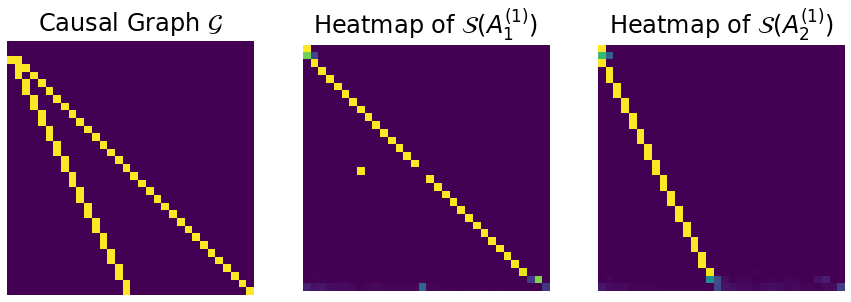

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
plt.sca(axs[0])
plt.imshow(A)
plt.title(r"Causal Graph $\mathcal{G}$", fontsize=24, y=1.02)
plt.axis("off")

plt.sca(axs[1])
plt.imshow(
    nn.softmax(
        jnp.where(jnp.tri(seq_len), model.A[0][0][vocab_size:, vocab_size:], -jnp.inf)
    )
)
plt.title(r"Heatmap of $\mathcal{S}(A_1^{(1)})$", fontsize=24, y=1.02)
plt.axis("off")

plt.sca(axs[2])
plt.imshow(
    nn.softmax(
        jnp.where(jnp.tri(seq_len), model.A[0][1][vocab_size:, vocab_size:], -jnp.inf)
    )
)
plt.axis("off")
plt.title(r"Heatmap of $\mathcal{S}(A_2^{(1)})$", fontsize=24, y=1.02)
plt.savefig("figs/multi.png")

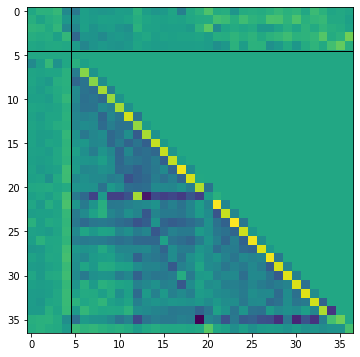

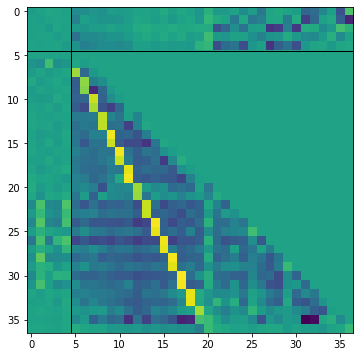

In [11]:
for i in range(len(model.A[0])):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(model.A[0][i], aspect="equal")
    n_box = len(model.A[0][i]) // (vocab_size + seq_len)
    for cutoff in np.cumsum([vocab_size, seq_len] * n_box)[:-1]:
        plt.axhline(cutoff - 1 / 2, c="k", lw=1)
        plt.axvline(cutoff - 1 / 2, c="k", lw=1)

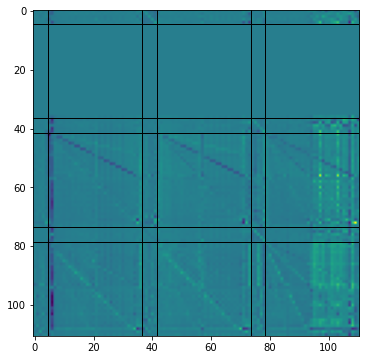

In [12]:
fig = plt.figure(figsize=(6, 6))
plt.imshow(model.A[1][0], aspect="equal")
n_box = len(model.A[1][0]) // (vocab_size + seq_len)
for cutoff in np.cumsum([vocab_size, seq_len] * n_box)[:-1]:
    plt.axhline(cutoff - 1 / 2, c="k", lw=1)
    plt.axvline(cutoff - 1 / 2, c="k", lw=1)

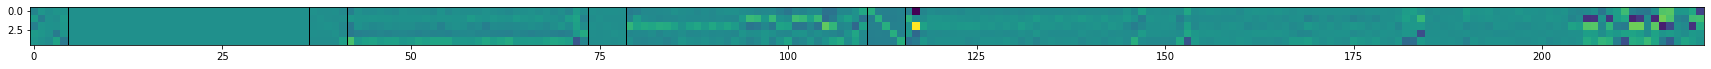

In [13]:
fig = plt.figure(figsize=(30, 4))
plt.imshow(model.W.T, aspect="equal")
for cutoff in np.cumsum([vocab_size, seq_len] * 4)[:-1]:
    plt.axvline(cutoff - 1 / 2, c="k", lw=1)